In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
from typing import Literal

torch.cuda.is_available()

True

In [2]:
from Encoding import GetEdgeIdx
class DEM_Dataset(InMemoryDataset):
    def __init__(self,file_name: str,data_split,
                 Dataset_type: Literal["train","validate","test"],
                 mode: Literal["cart","delta"],
                 root: str = os.getcwd()+r"\Data", 
                 force_reload=False,transform=None, pre_transform=None, pre_filter=None):
        
        self.raw_data_path = f"{root}\\raw"
        self.processed_data_path = f"{root}\\processed"
        self.file_name = file_name
        self.Dataset_type = Dataset_type
        self.mode = mode
        self.data_split = data_split
        super(DEM_Dataset,self).__init__(root, transform, pre_transform,pre_filter,force_reload)
        self.load(os.path.join(self.processed_data_path,self.processed_file_names[0]))

    @property 
    def raw_file_names(self):
        return[f"{self.file_name}_Data.npy",
               f"{self.file_name}_Topology.npy"]
    
    @property
    def processed_file_names(self):
        if self.pre_filter is None: return [f"{self.file_name}_{self.mode}_{self.Dataset_type}.pt"]
        else: return [f"{self.file_name}_{self.mode}_{self.Dataset_type}_init.pt"]
    
    def download(self):
        pass
    
    # Load data and split them according to dataset split
    def LoadSimTop(self,i):
        data = np.load(f"{self.raw_data_path}\\{self.raw_file_names[i]}",allow_pickle=True)
        Daset_type_idx = {"train":0,"validate":1,"test":2}[self.Dataset_type]
        splits=np.array(self.data_split)*data.shape[0]
        return np.split(data,splits.astype(int))[Daset_type_idx]
    
    def process(self):
            data_list = []
            simulations,topologies = [self.LoadSimTop(i) for i in [0,1]]

            if self.pre_filter is not None:
                simulations = self.pre_filter(simulations)

            for sim, top in tqdm(zip(simulations,topologies)):
                  for t in np.arange(len(sim)-1):
                    real_idx = sim[t][:,-1:].squeeze().nonzero()
                    maskx = np.squeeze(sim[t][:,-1:]==1)
                    if t == 1: start = False
                    x = torch.tensor(sim[t],dtype=torch.float)
                    y_abs = torch.tensor(sim[t+1][real_idx,:3],dtype=torch.float).squeeze()
                    if self.mode == 'cart':
                        y=y_abs
                    if self.mode == 'delta':
                        y=y_abs-x[maskx,:3]

                    edge_index = GetEdgeIdx(top[t],real_idx) 
                    data = Data(pos=x[:,:3],x=x[:,3:],y=y,edge_index=edge_index,mask=maskx,time=t)
                    data_list.append(data)

            if self.pre_transform is not None:
                data_list = [self.pre_transform(data) for data in data_list]        
                
            self.save(data_list, os.path.join(self.processed_data_path,self.processed_file_names[0]))

In [3]:
class RelPosConv(MessagePassing):
    def __init__(self, emb_dim, msg_dim, out_channels, aggr = 'mean'):
        super().__init__(aggr=aggr)
        self.edge_mlp = torch.nn.Linear(emb_dim+emb_dim,msg_dim)
        self.update_mlp = torch.nn.Linear(emb_dim+msg_dim,out_channels)
        self.reset_parameters()

    def forward(self,x,edge_attr,edge_index):
        out = self.propagate(edge_index,x=x,edge_attr=edge_attr)
        return out
    
    def message(self, x_j, edge_attr):
        tmp = torch.cat([x_j, edge_attr],dim=1)
        return self.edge_mlp(tmp)
    
    def update(self,aggr_out,x):
        cat = torch.cat([x, aggr_out],dim=1)
        return self.update_mlp(cat)

In [4]:
class GCONV_Model_RelPos(torch.nn.Module):
    def __init__(self, emb_dim=64, msg_dim=64, node_dim=7, edge_dim=3, out_dim = 3):
        super(GCONV_Model_RelPos,self).__init__()
        self.node_embed = torch.nn.Linear(node_dim,emb_dim)
        self.edge_embed = torch.nn.Linear(edge_dim,emb_dim)
        self.conv1 = RelPosConv(emb_dim,msg_dim,emb_dim)
        self.conv2 = RelPosConv(emb_dim,msg_dim,emb_dim)
        self.conv3 = RelPosConv(emb_dim,msg_dim,out_dim)

    def forward(self,data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index
        x = self.node_embed(x)
        edge_attr = self.edge_embed(edge_attr)
        x = F.relu(x)
        x = self.conv1(x, edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_attr, edge_index)
        return x

In [5]:
class Trainer:
    def __init__(self,model,dataset_train,dataset_val,batch_size,lr,epochs,model_name,loss_fn=torch.nn.MSELoss()):
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
        print("Device: ", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr)
        self.train_dl = self.make_data_loader(dataset_train, shuffle=True)
        self.val_dl = self.make_data_loader(dataset_val, shuffle=False)

    def make_data_loader(self, dataset, shuffle):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def loss_batch(self, batch,opt=None):
        out = self.model(batch)
        mask = np.concatenate(batch.mask)
        loss =self.loss_fn(out[mask], batch.y)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
        return loss.item()

    def batch_loop(self, dataloader, loss_list, axes, opt=None):
        mean_loss = 0
        for i, batch in enumerate(dataloader):
            batch_loss = self.loss_batch(batch.to(self.device), opt)
            mean_loss += batch_loss
        mean_loss /= i
        loss_list.append(mean_loss)
        axes[0].plot(loss_list)
        axes[1].plot(loss_list[-5:])
        return mean_loss,loss_list

    def train_loop(self):
        train_loss, val_loss = [], []
        best_model_loss = np.inf
        for epoch in tqdm(range(self.epochs)):
            clear_output(wait=True)
            fig, axes = plt.subplots(1,2)
            fig.set_figwidth(15)

            self.model.train()  
            mean_train_loss, train_loss = self.batch_loop(self.train_dl,train_loss,axes,self.optimizer)

            self.model.eval()
            with torch.inference_mode():
                mean_val_loss, val_loss = self.batch_loop(self.val_dl,val_loss,axes)

            for ax in axes: ax.set(xlabel='Epoch',ylabel='Loss'), ax.set_ylim(ymin=0), ax.set_xlim(xmin=0)

            plt.show()

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(),os.path.join(os.getcwd(),"Models",self.model_name))

            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")
        np.save(f"{os.getcwd()}\\Models\\{self.model_name}_Training_Loss",train_loss)
        np.save(f"{os.getcwd()}\\Models\\{self.model_name}_Validation_Loss",val_loss)

In [6]:
transform_norm = T.Compose([T.NormalizeScale(),T.Cartesian(False)])
transform_eq = T.Cartesian(False)

file_name="2Sphere"
data_split=[0.85, 0.95]
transform = transform_eq

dataset_train     = DEM_Dataset(file_name, data_split,"train"   ,'delta', pre_transform=transform,force_reload=True)
dataset_val       = DEM_Dataset(file_name, data_split,"validate",'delta', pre_transform=transform,force_reload=True)
dataset_test      = DEM_Dataset(file_name, data_split,"test"    ,'delta', pre_transform=transform,force_reload=True)

Processing...
1700it [01:27, 19.38it/s]
Done!
c:\Users\20182319\AppData\Local\anaconda3\envs\DEM-GNN\Lib\site-packages\torch_geometric\io\fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "
Processing...
200it [00:08, 24.98it/s]
Done!
Processing...
100it [00:07, 12.80it/s]
Done!


In [8]:
model = GCONV_Model_RelPos()
trainer = Trainer(model, dataset_train,dataset_val,
                  batch_size=64,
                  lr=0.00000001,
                  epochs=1000,
                  model_name=f"{file_name}_GCONV_Model_RelPos_03")
#trainer.train_loop()

Device:  cuda


c:\Users\Gebruiker\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
from Encoding import ToPytorchData
from Plotting import PlotGraph

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits

def Rollout(model,data_agr,bc_agr,i: int,model_name: str,timesteps: int,plot_graph: bool,
            device: Literal["cuda","cpu"],
            mode: Literal["cart","delta"]):
    model.load_state_dict(torch.load(f"{os.getcwd()}\\Models\\{model_name}",weights_only=True))
    model.eval()
    with torch.inference_mode():
        #par_t = np.copy(data_start[i])
        mask = data_agr[i][0][:,-1] == 1
        par_t = np.copy(data_agr[i][0][mask,:6])
        ML_rollout = np.zeros((timesteps+1,par_t.shape[0],par_t.shape[1]))
        ML_rollout[0] = par_t

        bc = np.copy(bc_agr[i])
        bc_t = np.copy(bc)
        bc_rollout = np.zeros((timesteps+1,6,9))
        bc_rollout[0] = bc_t

        for t in tqdm(range(timesteps)):
            bc_t[:,:3] = bc[:,:3]+(t+2)*bc[:,-3:]                      # Update BC's
            data = ToPytorchData(par_t,bc_t,tol=0.1)
            data = transform(data)
            if t == 0: limits = GetLimits(data)
            if plot_graph==True: PlotGraph(data,limits,manual_axes=False,plot_lines=False) 
            data.to(device)
            model.to(device)
            out = model(data)
            if mode == "cart":
                par_t[:,:3] = np.array(out[data.mask])
            if mode == "delta":
                par_t[:,:3] = par_t[:,:3]+np.array(out[data.mask])
            ML_rollout[t+1] = par_t

            bc_rollout[t+1] = bc_t
        return bc_rollout, ML_rollout

In [10]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

dataset_test_start = FilterStart(dataset_test)

In [11]:
dataset_test_start[0]

Data(x=[8, 7], edge_index=[2, 8], y=[2, 3], pos=[8, 3], time=0, mask=[8], edge_attr=[8, 3])

In [12]:
from Encoding import load
file_name = "2Sphere"
model_name = f"{file_name}_GCONV_Model_RelPos_02"
data_start,data_agr,top_agr,bc_agr = load(file_name)
model = GCONV_Model_RelPos()
bc_rollout, ML_rollout = Rollout(model,
                                 data_agr,
                                 bc_agr,-5,model_name,100,False,"cpu","delta")

100%|██████████| 100/100 [00:00<00:00, 406.76it/s]


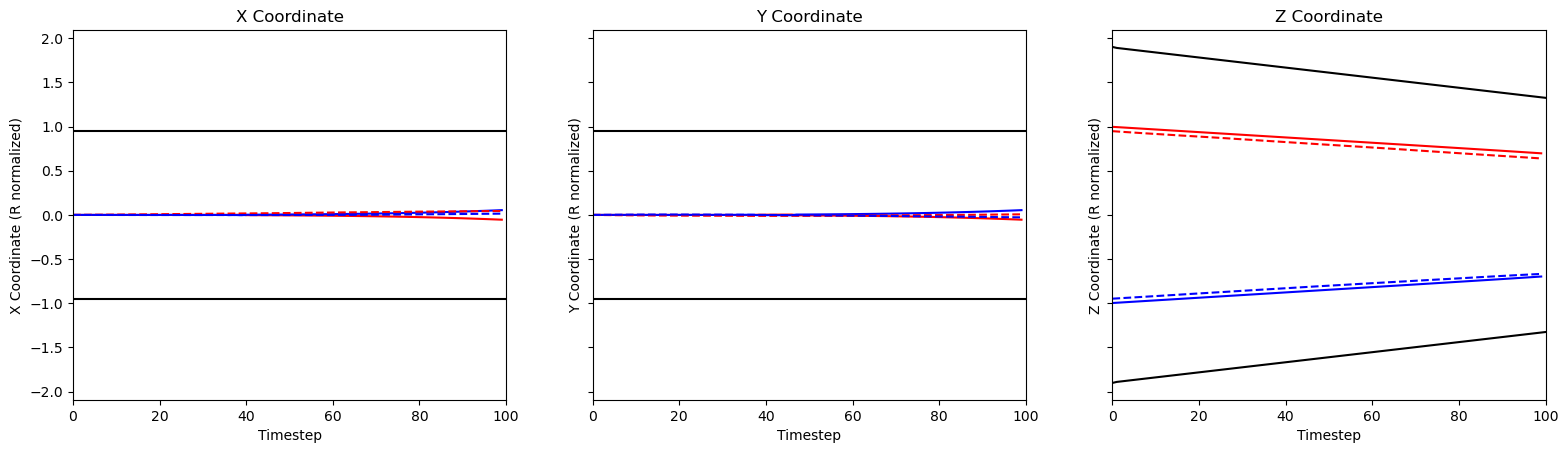

In [ ]:
from Plotting import PlotXYZ
fig, axes = plt.subplots(1,3,sharey=True)
fig.set_figwidth(19)
t_max = 100
for i, ax in enumerate(axes):   
    PlotXYZ(bc_rollout,data_agr[0][:t_max],ML_rollout[:t_max], i,ax)
    ax.set_xlim(xmin=0,xmax=t_max)